# Data Handling

This section explores data handling concepts that are beneficial when creating surrogate models, especially in engineering modeling applications. While working with data obtained in engineering work, the design variables or features of the data may have vastly different magnitudes. For example, when working with data from engineering structures, stress-related quantities could be on the order of $10^6$ Pa while the dimensions of the structure could be on the order of $10^{-3}$ m. The variables of interest in this case vary by several orders of magnitude. Due to the large variation in the orders of magnitude in the data, it can be hard to use it to create a surrogate model directly. Typically, it is hard to train the models when the input variables can vary by several orders of magnitude. To make it easier to create surrogate models in such situations, data scaling is applied to bring each variable to the same order of magnitude or within the same range of values. 

To demonstrate the use of scaling, the [Torsion Vibration](https://smt.readthedocs.io/en/latest/_src_docs/problems/torsionvibration.html) function will be used. It is a 15-dimensional function with the values of design variables varying from the order of $10^7$ to $10^{-2}$. This is an example of an engineering problem where the variables of interest have a large variation in order of magnitude. Radial basis function (RBF) models will be used to model the [Torsion Vibration](https://smt.readthedocs.io/en/latest/_src_docs/problems/torsionvibration.html) problem. More details about RBF models and their implementation will be covered in a future section of this Jupyter Book. Normalization and Standardization scaling will be applied to the data of the function and the NRMSE of the prediction of the model will be calculated for different numbers of training samples. 

The block of code below defines the [Torsion Vibration](https://smt.readthedocs.io/en/latest/_src_docs/problems/torsionvibration.html) function implemented using the [SMT](https://github.com/SMTorg/smt) package. 

> __*NOTE*__: To use the Torsion Vibration function, it is necessary to install the [SMT](https://github.com/SMTorg/smt) package. This should be done before running the code in this section. The package can be installed by running `pip install smt` after opening and activating the Python environment you created. 

In [1]:
# Defining the device and data types
import torch
tkwargs = {"device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'), "dtype": torch.float64}

from smt.problems import TorsionVibration # importing the tosion vibration function from SMT

# Defining the Torsion Vibration problem
ndim = 15
problem = TorsionVibration(ndim=ndim)

Since RBF models are used for this section, a function is defined to find the best $\sigma$ for the RBF model for given training and testing data. This function is similar to the one present in the RBF section of the Jupyter book with the addition of two arguments providing the scaling methods for the input and output data. Further discussion on this is given in the RBF section of the Jupyter Book. 

In [2]:
from scimlstudio.models import RBF # importing the RBF model
import numpy as np
from scimlstudio.utils.evaluation_metrics import evaluate_scalar # importing to calculate nrmse metric
from scimlstudio.utils import Normalize, Standardize

def find_sigma(x_train: torch.Tensor, y_train: torch.Tensor, x_test: torch.Tensor, y_test: torch.Tensor, sigmas: torch.Tensor, 
               input_transform: Normalize | Standardize | None, output_transform: Normalize | Standardize | None):
    """
        This function finds the best sigma for a RBF model by fitting the model to the training data and
        evaluating it on testing data. The best sigma is the one that achieves minimum normalized RMSE.

        Parameters
        ----------
        x_train : tensor array
            Training data x values
        y_train : tensor array
            Training data y values
        x_test : tensor array
            Testing data x values
        y_test : tensor array
            Testing data y values
        sigmas : tensor array
            Sigmas to be tested
        input_transform : Normalize or Standardize object or None
            Object of the Normalize or Standardize class indicating the 
            transformation required for the input variables
        output_transform : Normalize or Standardize object or None
            Object of the Normalize or Standardize class indicating the 
            transformation required for the output variables

        Returns
        -------
        best_sigma : float
            Best sigma value
        metric : list
            List of NRMSE values for each sigma
    """

    # Initializing normalized RMSE list
    metric = []

    # Fitting various polynomials
    for sigma in sigmas:

        # Fit the RBF
        rbf = RBF(x_train=x_train, y_train=y_train, sigma=sigma.item(), basis="gaussian",
                  input_transform=input_transform, output_transform=output_transform)
        _, _ = rbf.fit()

        # Predict at test values
        y_test_pred = rbf.predict(x_test)

        # Calculating the nrmse of the values
        nrmse = evaluate_scalar(y_test.reshape(-1,), y_test_pred.reshape(-1,), metric="nrmse")
            
        # Calculating average nrmse
        metric.append(nrmse)

    best_sigma = sigmas[np.argmin(metric)]

    return best_sigma, metric

## Normalization Scaling

Normalization scales all of the design variables to a specified range using the minimum and maximum values of the variables in the data. The first step of normalization is to scale the variables to a range of $[0,1]$ using the minimum and maximum values. This scaling can be obtained as

$$X_{norm} = \frac{X-X_{min}}{X_{max}-X_{min}}$$

where $X$ is the input/output data for the model and $X_{min}$ and $X_{max}$ are the minimum and maximum values of the input/output features. If the desired range for the data is $[0,1]$, then no further steps are required. However, if the desired range for the data is $[\min, \max]$, then $X_{std}$ must be further scaled to the required range

$$X_{scaled}=X_{norm}(\text{max} - \text{min}) + \text{min}$$

The block of code below uses the `Normalize` class from `scimlstudio` to normalize the data obtained for the Torsion Vibration function. An RBF model is fit to both the scaled and unscaled data for different numbers of training samples. Predictions are made on the testing data for the function and the NRMSE values are calculated for the predictions. 

In [3]:
from pyDOE3 import halton_sequence, lhs

# Creating testing data for the problem using halton sequences
x = halton_sequence(num_points=100, dimension=15)
lb = problem.xlimits[:,0]
ub = problem.xlimits[:,1]
xtest = lb + (ub - lb) * x
ytest = problem(xtest)

# Converting to torch tensors
x_test = torch.tensor(xtest, **tkwargs)
y_test = torch.tensor(ytest, **tkwargs)

# Defining the number of samples
samples = [5,10,15,20,25,30,35,40,45,50]

scaled_nrmse = []
nrmse = []

for sample in samples:
    # Creating a model with and without scaling
    num = sample
    X = lhs(n=problem.xlimits.shape[0], samples=num, criterion="cm", iterations=100)
    xtrain = lb + (ub - lb) * X
    ytrain = problem(xtrain)

    # Converting to torch tensors
    x_train = torch.tensor(xtrain, **tkwargs)
    y_train = torch.tensor(ytrain, **tkwargs)
    
    input_transform = Normalize(x_train)
    output_transform = Normalize(y_train)
    
    sigmas = np.logspace(-15, 15, 100)
    best_sigma, test_metric = find_sigma(x_train, y_train, x_test, y_test, sigmas, input_transform=None, output_transform=None)
    best_sigma_scaled, test_metric_scaled = find_sigma(x_train, y_train, x_test, y_test, sigmas, input_transform=input_transform, output_transform=output_transform)
    
    # Fitting RBF using scaled data
    rbf_scaled = RBF(x_train=x_train, y_train=y_train, sigma=best_sigma_scaled, basis="gaussian", input_transform=input_transform, output_transform=output_transform)
    scaled_weights, scaled_basis_matrix = rbf_scaled.fit()
    y_scaled_pred = rbf_scaled.predict(x_test)
    
    # Fitting RBF using unscaled data
    rbf_unscaled = RBF(x_train=x_train, y_train=y_train, sigma=best_sigma, basis="gaussian")
    unscaled_weights, unscaled_basis_matrix = rbf_unscaled.fit()
    y_unscaled_pred = rbf_unscaled.predict(x_test)
    
    scaled_nrmse.append(evaluate_scalar(y_test.reshape(-1,), y_scaled_pred.reshape(-1,), metric="nrmse"))
    nrmse.append(evaluate_scalar(y_test.reshape(-1,), y_unscaled_pred.reshape(-1,), metric="nrmse"))

The next block of code will plot the NRMSE values against the number of training samples for both the scaled and unscaled data.

Text(0, 0.5, 'Normalized RMSE')

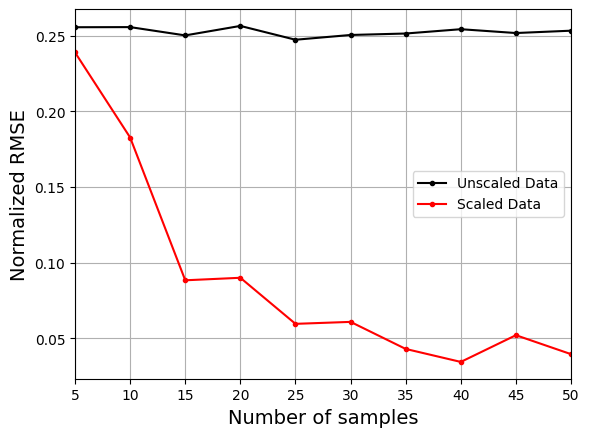

In [4]:
# Plotting NMRSE
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(samples, np.array(nrmse), c="k", marker=".", label = "Unscaled Data")
ax.plot(samples, np.array(scaled_nrmse), c="r", marker=".", label = "Scaled Data")
ax.grid(which="both")
ax.legend(loc="center right")
ax.set_xlim((samples[0], samples[-1]))
ax.set_xlabel("Number of samples", fontsize=14)
ax.set_ylabel("Normalized RMSE", fontsize=14)

The plot above shows that using the scaled data to create the model consistently leads to lower NRMSE values than the model created using the unscaled data. It is difficult to train the model using the unscaled data and there is little to no improvement in the NRMSE values as the number of samples increases.

## Standardization Scaling

Standardization scales the data to be of mean 0 and standard deviation 1. The first step of the scaling is to calculate the mean ($\mu$) and standard deviation ($\sigma$) of each feature in the input or output data. Once the $\mu$ and $\sigma$ are calculated, the data can be scaled as 

$$X_{scaled} = \frac{X-\mu}{\sigma}$$

The block of code below uses the `Standardize` class from `scimlstudio` to standardize the data obtained for the Torsion Vibration function. An RBF model is fit to both the scaled and unscaled data for different numbers of training samples. Predictions are made on the testing data for the function and the NRMSE values are calculated for the predictions. 

In [5]:
# Creating testing data for the problem using halton sequences
x = halton_sequence(num_points=100, dimension=15)
lb = problem.xlimits[:,0]
ub = problem.xlimits[:,1]
xtest = lb + (ub - lb) * x
ytest = problem(xtest)

# Converting to torch tensors
x_test = torch.tensor(xtest, **tkwargs)
y_test = torch.tensor(ytest, **tkwargs)

# Defining the number of samples
samples = [5,10,15,20,25,30,35,40,45,50]

scaled_nrmse = []
nrmse = []

for sample in samples:
    # Creating a model with and without scaling
    num = sample
    X = lhs(n=problem.xlimits.shape[0], samples=num, criterion="cm", iterations=100)
    xtrain = lb + (ub - lb) * X
    ytrain = problem(xtrain)

    # Converting to torch tensors
    x_train = torch.tensor(xtrain, **tkwargs)
    y_train = torch.tensor(ytrain, **tkwargs)
    
    input_transform = Standardize(x_train)
    output_transform = Standardize(y_train)
    
    sigmas = np.logspace(-15, 15, 100)
    best_sigma, test_metric = find_sigma(x_train, y_train, x_test, y_test, sigmas, input_transform=None, output_transform=None)
    best_sigma_scaled, test_metric_scaled = find_sigma(x_train, y_train, x_test, y_test, sigmas, input_transform=input_transform, output_transform=output_transform)
    
    # Fitting RBF using scaled data
    rbf_scaled = RBF(x_train=x_train, y_train=y_train, sigma=best_sigma_scaled, basis="gaussian", input_transform=input_transform, output_transform=output_transform)
    scaled_weights, scaled_basis_matrix = rbf_scaled.fit()
    y_scaled_pred = rbf_scaled.predict(x_test)
    
    # Fitting RBF using unscaled data
    rbf_unscaled = RBF(x_train=x_train, y_train=y_train, sigma=best_sigma, basis="gaussian")
    unscaled_weights, unscaled_basis_matrix = rbf_unscaled.fit()
    y_unscaled_pred = rbf_unscaled.predict(x_test)
    
    scaled_nrmse.append(evaluate_scalar(y_test.reshape(-1,), y_scaled_pred.reshape(-1,), metric="nrmse"))
    nrmse.append(evaluate_scalar(y_test.reshape(-1,), y_unscaled_pred.reshape(-1,), metric="nrmse"))

The next block of code will plot the NRMSE values against the number of training samples for both the scaled and unscaled data.

Text(0, 0.5, 'Normalized RMSE')

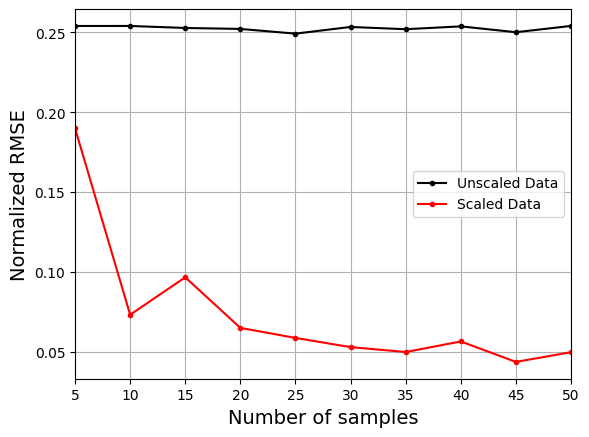

In [6]:
# Plotting NMRSE
fig, ax = plt.subplots()
ax.plot(samples, np.array(nrmse), c="k", marker=".", label = "Unscaled Data")
ax.plot(samples, np.array(scaled_nrmse), c="r", marker=".", label = "Scaled Data")
ax.grid(which="both")
ax.legend(loc="center right")
ax.set_xlim((samples[0], samples[-1]))
ax.set_xlabel("Number of samples", fontsize=14)
ax.set_ylabel("Normalized RMSE", fontsize=14)

Similar to normalization, the plot above shows that using the scaled data to create the model consistently leads to lower NRMSE values than the model created using the unscaled data. It is difficult to train the model using the unscaled data and there is little to no improvement in the NRMSE values as the number of samples increases.